# Extract Paraphrases

In [2]:
from collections import defaultdict
from emo20q.gamedata import HumanHumanTournament

def collect_paraphrases(hht) -> dict:
    """returns a dict with gloss/semantic annotation as the key and a set
    of examples as the values
    """
    paraphrase_dict = defaultdict(set)
    for m in hht.matches:
        for t in m.turns:
            paraphrase_dict[t.qgloss].add(t.q)

    return paraphrase_dict

In [3]:
pd = make_paraphrase(HumanHumanTournament())

In [5]:
len(pd.keys())

700

In [10]:
# c.f. https://realpython.com/python-histograms/
def count_elements(seq) -> dict:
     """Tally elements from `seq`."""
     hist = {}
     for i in seq:
         hist[i] = hist.get(i, 0) + 1
     return hist

def ascii_histogram(seq) -> None:
    """A horizontal frequency-table/histogram plot."""
    counted = count_elements(seq)
    for k in sorted(counted):
        print('{0:5d} {1}'.format(k, '+' * counted[k]), f"({counted[k]})")

In [12]:
ascii_histogram([len(pd[k]) for k in pd.keys()])

    1 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ (553)
    2 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ (73)
    3 +++++++++++++++++++++++++++++++++++++ (37)
    4 +++++++++++ (11)
    5 ++++++++++ (10)
    6 ++++++ (6)
    7 ++++ (4)
   10 ++ (2)
   11 + (1)
   21 + (1)
   35 + (1)
   41 + (1)


In [13]:
len([len(pd[k]) for k in pd.keys() if len(pd[k])>1])

147

In [15]:
# the previous is kind of ugly, try a different way
count_non_hapax_glosses = 0
for k in pd:
    if len(pd[k]) > 1:
        count_non_hapax_glosses += 1
print(count_non_hapax_glosses)

147


In [16]:
count_non_hapax_instances = 0
for k in pd:
    if len(pd[k]) > 1:
        count_non_hapax_instances += len(pd[k])
print(count_non_hapax_instances)

543


There are a lot of paraphrases with single examples, but a fair amount, 147, that have 2 or more examples for a given gloss, for a total of 543 different questions.

For comparison, the Microsoft Research Paraphrase Corpus (MRPC) has the following size
Size of training dataset: 3668.
Size of evaluation dataset: 408.
Maximum sequence length of training and evaluation dataset: 128

The format of the BERT input for paraphrase data is class, sentA, sentB.  Assuming that order matters (permutation, not combination), this would be $nPr = \frac{n!}{(n-r)!}$ or $\frac{543!}{541!} = 543*542$

In [18]:
543*542

294306

so actually a fair amount more data than MRPC (though I should read their paper to make sure I'm not missing something)

This is also assuming we wouldn't include the same sentence as both sentA and sentB (of course then the total would be 543*543)

In [20]:
num_positive_examples = 0
for k in pd:
    if len(pd[k]) > 1:
        num_positive_examples += len(pd[k])*(len(pd[k])-1)
print(num_positive_examples)

4588


so if we try to make it balanced in terms of number of positive and negative examples it might be closer to the size of the MRPC data (if we downsample the negative examples instead of upsampling the positive).

Of course, if we include the hapaxes (glosses that were only seen once), then we could have a lot more negative examples

In the MRPC data, the breakdown of positive (paraphrase) to negative (not paraphrase) is 2474 to 1194, i.e. twice as many positive examples as negative or 2/3rds positive.

In [23]:
2474/(3668-2474)

2.0720268006700167

In [24]:
2474/3668

0.6744820065430752

# create train/dev/test sets

Okay then, let's create our train/dev/test data...

I think for publication, I should do something like holding out some of the glosses (doing the train/dev/test partition at the gloss level), however I feel like doing something easy to start.

In [43]:
positive_examples = []
negative_examples = []
for k in pd:
    if len(pd[k]) > 1:
        for s1 in pd[k]:
            for s2 in pd[k]:
                if s1 != s2:
                    positive_examples.append((s1, s2))
                    
print(len(positive_examples))

for k1 in pd:
    for k2 in pd:
        if k1 != k2: # not paraphrases, i.e. they don't have the same gloss k1/k2
            if len(pd[k1]) > 1 and len(pd[k2]) > 1: # remove this to keep the hapax glosses
                for s1 in pd[k1]:
                    for s2 in pd[k2]:
                        negative_examples.append((s1, s2))

print(len(negative_examples))
print(len(positive_examples) + len(negative_examples))

4588
289718
294306


good, the numbers match up to what we calculated earlier.

In [35]:
import numpy as np
import tensorflow as tf

In [89]:
data = positive_examples + negative_examples
sentA, sentB = zip(*data)
idx = np.array(range(0,len(data)))
labels = np.concatenate([np.ones(len(positive_examples)), np.zeros(len(negative_examples))])

# shuffle index
np.random.seed(0)
np.random.shuffle(idx)

# convert to tensorflow and shuffle other data
#print(tf.data.Dataset.from_tensor_slices(labels))
idx = tf.constant(idx)
print(idx)

labels = tf.constant(labels)
labels = tf.gather(labels, idx)
print(labels)

sentA = tf.constant(sentA)
sentA = tf.gather(sentA, idx)
print(sentA)

sentB = tf.constant(sentB)
sentB = tf.gather(sentB, idx)
print(sentB)

# sanity check: recover the positive examples
positive_idx = np.where(labels==1)
print("the next couple examples should match up as paraphrases")
print(tf.gather(sentA, positive_idx))
print(tf.gather(sentB, positive_idx))

tf.Tensor([ 46758  98930  19086 ... 122579 152315 117952], shape=(294306,), dtype=int64)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(294306,), dtype=float64)
tf.Tensor(
[b'is it like anger?' b'is it similar to excited?' b'ok is it positive'
 ... b'did we already say calm?' b'is it worrying?' b'serene?'], shape=(294306,), dtype=string)
tf.Tensor(
[b'close to surprised?'
 b'is there a wide range of intensities that this emotion can be felt?'
 b'10)similar to disappointed?' ... b'cool, is it a negative emotion?'
 b'Is the emotion usually caused by certain situations (as opposed to just popping up in your mind)?'
 b'is it affection?'], shape=(294306,), dtype=string)
the next couple examples should match up as paraphrases
tf.Tensor(
[[b'ok is it a positive emotion?'
  b'do people feel that when they are helpless' b'is it posiitive?' ...
  b'3. Is it usually an intense emotion?'
  b'is it something you feel towards someone else?'
  b'would you feel it if you had an exam the next day?']], shape

now to partition the data.  I'm going to use the format [here](https://github.com/tensorflow/models/blob/master/official/colab/fine_tuning_bert.ipynb).  

Out of N=294306, I'll set $N_{train}=200000$ , $N_{validation}=14306$, and $N_{test}=80000$

In [96]:
emo20q_paraphrase = {}

emo20q_paraphrase['train'] = {'sentence1': tf.slice(sentA, [0], [200000]),
                              'sentence2': tf.slice(sentB, [0], [200000]),
                              'idx': tf.slice(idx, [0], [200000]),
                              'label': tf.slice(labels, [0], [200000])}

emo20q_paraphrase['validation'] = {'sentence1': tf.slice(sentA, [200000], [14306]),
                                   'sentence2': tf.slice(sentB, [200000], [14306]),
                                   'idx': tf.slice(idx, [200000], [14306]),
                                   'label': tf.slice(labels, [200000], [14306])}

emo20q_paraphrase['test'] = {'sentence1': tf.slice(sentA, [214306], [80000]),
                             'sentence2': tf.slice(sentB, [214306], [80000]),
                             'idx': tf.slice(idx, [214306], [80000]),
                             'label': tf.slice(labels, [214306], [80000])}

# Get Bert Model 

again, this is based on https://github.com/tensorflow/models/blob/master/official/colab/fine_tuning_bert.ipynb


In [98]:
# get stable models garden
!pip install -q tf-models-official==2.4.0

You should consider upgrading via the '/Users/kaze7539/.virtualenvs/emo20q-notebook/bin/python -m pip install --upgrade pip' command.


In [99]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks


In [100]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [101]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [102]:
# more copy pasta
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)
tokens = tokenizer.tokenize("subset(e,nightmare)")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)


['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]
['subset', '(', 'e', ',', 'nightmare', ')']
[16745, 1006, 1041, 1010, 10103, 1007]


In [103]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [104]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in emo20q_paraphrase['train']["sentence1"]])
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in emo20q_paraphrase['train']["sentence2"]])

In [106]:
print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())

Sentence1 shape: [200000, None]
Sentence2 shape: [200000, None]


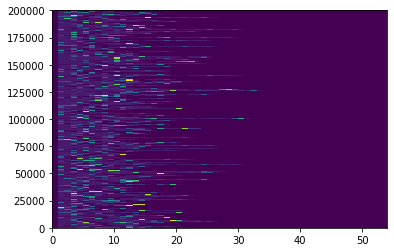

In [107]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

# imput mask and input type

the next part is to distinguish the content and the padding

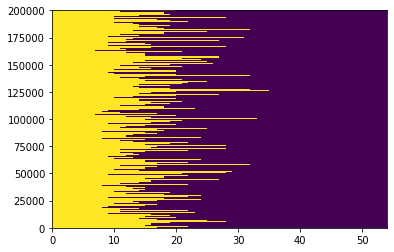

In [108]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

the next part distinguishes sentence 1 and 2

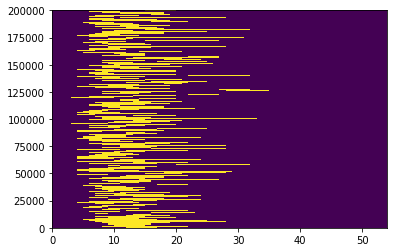

In [109]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [110]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [111]:
# I'm keeping the "glue" so that the parts of the example code still sticks together
glue_train = bert_encode(emo20q_paraphrase['train'], tokenizer)
glue_train_labels = emo20q_paraphrase['train']['label']

glue_validation = bert_encode(emo20q_paraphrase['validation'], tokenizer)
glue_validation_labels = emo20q_paraphrase['validation']['label']

glue_test = bert_encode(emo20q_paraphrase['test'], tokenizer)
glue_test_labels  = emo20q_paraphrase['test']['label']

In [112]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (200000, 54)
input_mask      shape: (200000, 54)
input_type_ids  shape: (200000, 54)
glue_train_labels shape: (200000,)


In [113]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [114]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

In [122]:
!pip install pydot
!pip install pydotplus
!pip install graphviz

You should consider upgrading via the '/Users/kaze7539/.virtualenvs/emo20q-notebook/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/kaze7539/.virtualenvs/emo20q-notebook/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/kaze7539/.virtualenvs/emo20q-notebook/bin/python -m pip install --upgrade pip' command.


In [125]:
# this wasn't working for my on my laptop, googling says to restart kernel but I don't want to restart everything
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [128]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()


array([[-0.44147053, -0.48081   ],
       [-0.4826107 , -0.56173587],
       [-0.17313254, -0.52167517],
       [-0.38307312, -0.6034557 ],
       [-0.44038168, -0.63063896],
       [-0.35595578, -0.42431045],
       [-0.41553512, -0.39635074],
       [-0.37771577, -0.51407313],
       [-0.42924854, -0.42798463],
       [-0.34307918, -0.41576943]], dtype=float32)

In [129]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


restore encoder weights

In [130]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

setup optimizer

In [132]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [133]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

train the model

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
 408/6250 [>.............................] - ETA: 10:40:57 - loss: 0.8754 - accuracy: 0.4040

now try the fine-tuned model on example sentences

In [ ]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

the model should report 1 for match and 0 for not

In [ ]:
result = bert_classifier(my_examples, training=False)

result = tf.argmax(result).numpy()
result

In [ ]:
np.array(info.features['label'].names)[result]

# save the model

In [ ]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

check to make sure that the saved model has the same results

In [ ]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())

# appendix